# Conversion Rate

In this challenge, we build a model that predicts the conversion rate and based on the model, come up with ideas to improve revenue.

Data include users who hit the website: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are
repeat users and the number of pages visited during that session (as a proxy for site
activity/time spent on site).

In [60]:
# data wrangling and visulization

import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# model and metrics
from sklearn.preprocessing import LabelEncoder
# from sklearn.compose import make_column_transformer
# from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, confusion_matrix
from sklearn.inspection import partial_dependence, plot_partial_dependence

## 1. Data overview

In [2]:
df = pd.read_csv('conversion_data.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


As seen in the above table that the feature "converted" which we will later build model to predict depend on 3 categorical features (country, new_user, source) and 2 numerical features (age, total_pages_visited).

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


We noticed that there is no missing values.

In [4]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [5]:
df['country'].value_counts()

US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64

In [6]:
df['source'].value_counts()

Seo       155040
Ads        88740
Direct     72420
Name: source, dtype: int64

Some quick observations:
* This is probably a US website, although Chinese user base is also large.
* user base is pretty young, but the maximum age is 123 yrs old which might be outliers.
* conversion rate is about 3% which is the industry standard. 

### Outliers

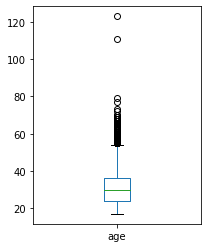

In [7]:
# Box plot of the feature "age"

df['age'].plot.box(figsize=(3, 4))
plt.show()

From this plot we see that the majority users are below the age 80.

In [8]:
# To be precise

np.sort(df['age'].unique())

array([ 17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  72,  73,  77,  79, 111, 123])

In [9]:
# Remove outliers

df = df[df['age']<79]
print("Data shape: ", df.shape)

Data shape:  (316197, 6)


## 2. Exploratory data analysis

As a prerequisite of all DS projects, we first do some EDA to get a sense of the data.

   country  converted
1  Germany   0.062428
2       UK   0.052612
3       US   0.037801
0    China   0.001332


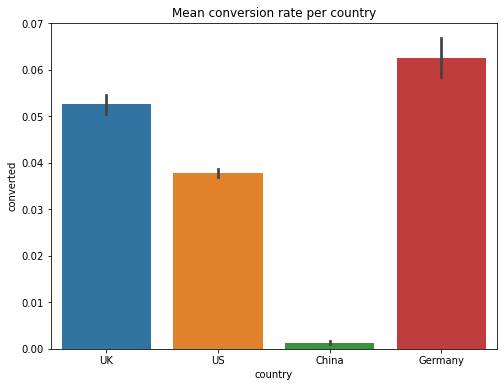

In [10]:
# Conversion rate for different countries

df_country = df[['country', 'converted']].groupby('country').mean().reset_index().sort_values(by='converted', ascending=False)
print(df_country)

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x='country', y='converted', data=df, ax=ax)
ax.set_title('Mean conversion rate per country')
plt.show()

The conversion rate in Chinese market is exceptionally low compared to others.

   new_user  converted
0         0   0.071983
1         1   0.014021


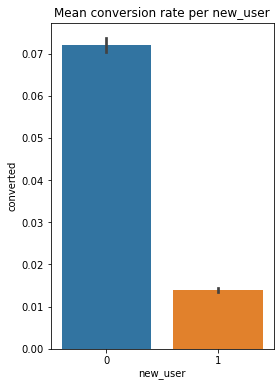

In [11]:
# Conversion rate for different users

df_user = df[['new_user', 'converted']].groupby('new_user').mean().reset_index().sort_values(by='converted', ascending=False)
print(df_user)

fig, ax = plt.subplots(figsize=(4, 6))
sns.barplot(x='new_user', y='converted', data=df, ax=ax)
ax.set_title('Mean conversion rate per new_user')
plt.show()

Apparently the old users tend to have much higher conversion rate.

   source  converted
0     Ads   0.034472
2     Seo   0.032888
1  Direct   0.028169


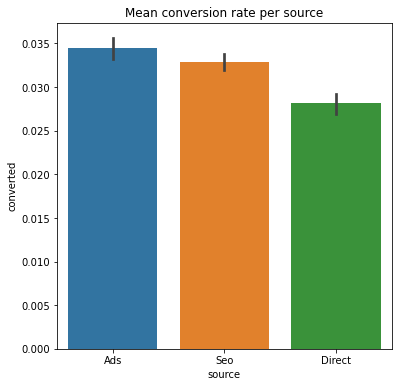

In [12]:
# Conversion rate for different source

df_source = df[['source', 'converted']].groupby('source').mean().reset_index().sort_values(by='converted', ascending=False)
print(df_source)

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x='source', y='converted', data=df, ax=ax)
ax.set_title('Mean conversion rate per source')
plt.show()

Seems the source doesn't matter much.

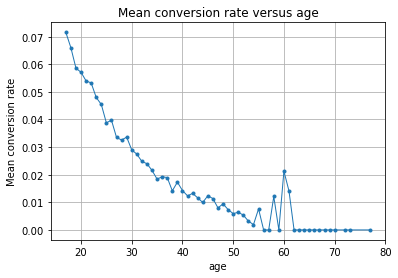

In [13]:
# Conversion rate versus age

df_age = df[['age', 'converted']].groupby('age').mean().reset_index()
# print(df_age)

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(df_age['age'], df_age['converted'], '.-')
ax = df_age.plot(x='age', y='converted', style=['.-'], linewidth=1.0, legend=None, grid=True) # you can also change color at style option
ax.set_title('Mean conversion rate versus age')
ax.set_xlabel('age')
ax.set_ylabel('Mean conversion rate')
ax.grid(True)
plt.show()

Conversion rate decreases with age.

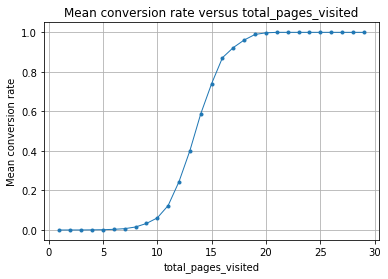

In [14]:
# Conversion rate versus total_pages_visited

df_page = df[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()
# print(df_age)

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(df_age['total_pages_visited'], df_age['converted'], '.-')
ax = df_page.plot(x='total_pages_visited', y='converted', style=['.-'], linewidth=1.0, legend=None, grid=True) # you can also change color at style option
ax.set_title('Mean conversion rate versus total_pages_visited')
ax.set_xlabel('total_pages_visited')
ax.set_ylabel('Mean conversion rate')
ax.grid(True)
plt.show()

Definitely spending more time on the site implies higher probability of conversion.

## 3. Feature encoding

Now we convert 2 nominal variable: source and country to numerical using feature encoding.

In [27]:
# Instantiate OneHotEncoder

le = LabelEncoder()

In [31]:
df['source'] = le.fit_transform(df['source'])
df['country'] = le.fit_transform(df['country'])

In [36]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,2,25,1,0,1,0
1,3,23,1,2,5,0
2,3,28,1,2,4,0
3,0,39,1,2,5,0
4,3,30,1,2,6,0


## 4. Build machine learning pipline

In [37]:
# Get predictor variables and target variable from data

X = df.drop('converted', axis=1)
Y = df['converted']

In [38]:
# Create training/test set with a 70% split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)

print("X_train_shape: ", X_train.shape)
print("Y_train_shape: ", Y_train.shape)
print("X_test_shape: ", X_test.shape)
print("Y_test_shape: ", Y_test.shape)

X_train_shape:  (221337, 5)
Y_train_shape:  (221337,)
X_test_shape:  (94860, 5)
Y_test_shape:  (94860,)


In [39]:
# Instantiate pipeline with random forest classifier

rfm = RandomForestClassifier(oob_score=True)
rfm_pipeline = make_pipeline(rfm)
rfm_pipeline.fit(X_train, Y_train)
rfm_predictions = rfm_pipeline.predict(X_test)

In [40]:
# OOB and test error.

print('OOB error is', 1 - rfm.oob_score_)
print('test error is', 1 - accuracy_score(Y_test, rfm_predictions))

OOB error is 0.015966602962902754
test error is 0.015359477124182952


So, OOB error and test error are pretty similar: 1.6% and 1.5%. We are confident we are not overfitting.
Error is pretty low. However, we started from a 97% accuracy (that’s the case if we classified everything
as “non converted”). So, 98.5% is good, but nothing shocking. Indeed, 30% of conversions are predicted
as “non conversion”.

In [41]:
print(f1_score(Y_test, rfm_predictions))
print(confusion_matrix(Y_test, rfm_predictions, normalize='all'))

0.7372407574391344
[[0.96309298 0.00527093]
 [0.01008855 0.02154754]]


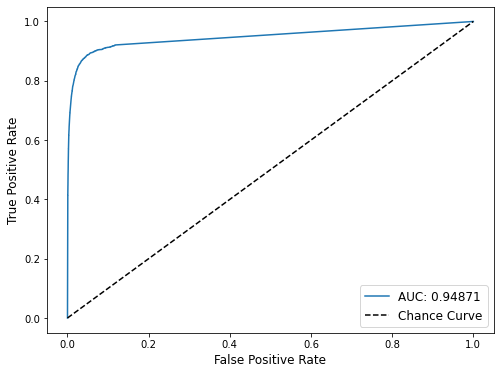

In [47]:
fpr, tpr, _ = roc_curve(Y_test, rfm.predict_proba(X_test)[:,1], pos_label=1)
# test_auc = metrics.auc(fpr, tpr)
# auc_val = np.trapz(tpr,fpr)

# Print ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
# plot_roc_curve(rfm, X_test, Y_test, name = 'Random Forest', ax=ax)
ax.plot(fpr, tpr, label = 'AUC: ' + str(np.round((roc_auc_score(Y_test, rfm.predict_proba(X_test)[:,1])), 5)))
ax.plot(fpr, fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

### Variable importance

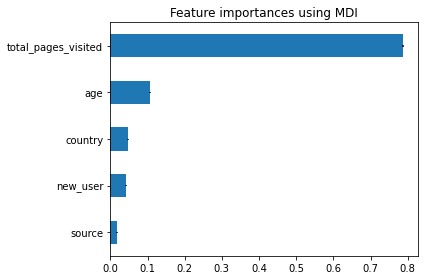

In [44]:
importances = rfm.feature_importances_
importances = pd.Series(importances)
importance_sorted = importances.sort_values()

std = np.std([tree.feature_importances_ for tree in rfm.estimators_], axis=0)

fig, ax = plt.subplots()
importance_sorted.plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_yticklabels(X_test.columns[[importances.sort_values().index.values]])
fig.tight_layout()
plt.show()

For both train and test sets, total pages visited is the most important one. However, it is also directly related to the conversion rate which is not "actionable". For the test set, new user is more important than age while in the train set it is opposite.  

### Model without "total_pages_visited"

In [48]:
X2 = df.drop(['converted','total_pages_visited'], axis=1)

In [49]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y, test_size = 0.3, random_state=42)

print("X2_train_shape: ", X2_train.shape)
print("Y2_train_shape: ", Y2_train.shape)
print("X2_test_shape: ", X2_test.shape)
print("Y2_test_shape: ", Y2_test.shape)

X2_train_shape:  (221337, 4)
Y2_train_shape:  (221337,)
X2_test_shape:  (94860, 4)
Y2_test_shape:  (94860,)


In [50]:
# Instantiate pipeline with random forest classifier

rfm2 = RandomForestClassifier(oob_score=True)
rfm2_pipeline = make_pipeline(rfm2)
rfm2_pipeline.fit(X2_train, Y2_train)
rfm2_predictions = rfm2_pipeline.predict(X2_test)

In [51]:
print(1 - rfm2.oob_score_)
print(1 - accuracy_score(Y2_test, rfm2_predictions))

0.03251602759592842
0.03163609529833433


The accuracy drops as we neglect the feature "total_pages_visited".

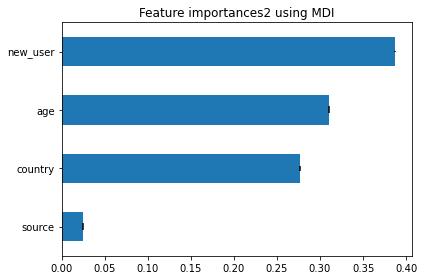

In [57]:
importances2 = rfm2.feature_importances_
importances2 = pd.Series(importances2)
importance_sorted = importances2.sort_values()

std = np.std([tree.feature_importances_ for tree in rfm2.estimators_], axis=0)

fig, ax = plt.subplots()
importance_sorted.plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances2 using MDI")
ax.set_yticklabels(X2_test.columns[[importances2.sort_values().index.values]])
fig.tight_layout()
plt.show()

The feature_importance now predicts that the most important one is the new_user, so we learn that users with an old account are much better than new users. Then it is the age and country. Again, the source doesn't really matter. 